## Group No
Assignment Group Number: 12

## Group Member Names:
1. Chandupatla Anirudh Reddy (BITS ID: 2022DA04387)
2. Ishmeet Singh Rana (BITS ID: 2022DA04175)
3. Nilanjana Roy (BITS ID: 2022AC05393)
4. Hiren Arvind Rambhia (BITS ID: 2022AC0568)


IMPORT LIBRARIES

In [149]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


# PREPROCESSING OF DATA

In [133]:
# Replace 'file_path.csv' with the path to your CSV file
file_path = '/content/data.csv'

# Read the CSV file into a pandas DataFrame
df = pd.read_csv(file_path,delimiter='\t')
print("Shape of DataFrame:", df.shape)

# Columns to encode
columns_to_encode = ['urban', 'gender', 'engnat', 'screensize',
                     'uniquenetworklocation', 'hand',
                     'religion','orientation', 'race', 'married', 'voted']
columns_categories = [[[1, 2, 3]],
                      [[1, 2, 3]],
                      [[1, 2]],
                      [[1, 2]],
                      [[1, 2]],
                      [[1, 2, 3]],
                      [[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]],
                      [[1, 2, 3 ,4, 5]],
                      [[10, 20, 30, 40, 50, 60, 70]],
                      [[1, 2, 3]],
                      [[1, 2]]]

for column, categories in zip(columns_to_encode,columns_categories):

  # Create an instance of OneHotEncoder
  one_hot_encoder = OneHotEncoder(sparse_output=False,handle_unknown='ignore',categories = categories)

  # Fit and transform the selected columns
  one_hot_encoded = one_hot_encoder.fit_transform(df[column].values.reshape(-1, 1))
  df_one_hot_encoded = pd.DataFrame(one_hot_encoded, columns = [column+str(int(i)) for i in range(one_hot_encoded.shape[1])])
  df = pd.concat([df, df_one_hot_encoded], axis=1)

  #droping the column
  df = df.drop([column], axis=1)

print("Shape of DataFrame after one-hot encoding:", df.shape)

# Remove rows with NaN values and 'country'& 'major' column
df.dropna(inplace=True)
df.drop(columns=['major'], inplace=True)
df.drop(columns=['country'], inplace=True)

print("Shape of DataFrame after NaN removal:", df.shape)

# Function to remove outliers using IQR
def remove_outliers_iqr(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df >= lower_bound) & (df <= upper_bound)].dropna()


# Generate a list of column names containing time taken to answer each of the 42 questions
column_names = [f"Q{i}E" for i in range(1, 43)]

# Apply the remove_outliers_iqr function to each column
#for column in column_names:
#    df[column] = remove_outliers_iqr(df[column])

df.dropna(inplace=True)

print("Shape of DataFrame after outliers removal:", df.shape)
print(df.head(10))


Shape of DataFrame: (39775, 172)
Shape of DataFrame after one-hot encoding: (39775, 205)
Shape of DataFrame after NaN removal: (28371, 203)
Shape of DataFrame after outliers removal: (28371, 203)
    Q1A  Q1I   Q1E  Q2A  Q2I   Q2E  Q3A  Q3I    Q3E  Q4A  ...  race2  race3  \
3     2   23  5081    3   11  6837    2   37   5521    1  ...    0.0    0.0   
4     2   36  3215    2   13  7731    3    5   4156    4  ...    0.0    0.0   
6     1   20  4325    1   34  4009    2   38   3604    3  ...    0.0    0.0   
7     1   34  4796    1    9  2618    1   39   5823    1  ...    0.0    0.0   
8     4    4  3470    4   14  2139    3    1  11043    4  ...    0.0    0.0   
9     3   38  5187    2   28  2600    4    9   2015    1  ...    0.0    0.0   
12    1   35  3055    1   24  1812    1   30   3266    1  ...    0.0    0.0   
13    1   28  2890    4   20  3910    1   26   3132    2  ...    0.0    0.0   
14    1   10  2901    1    1  9036    1   22   3775    1  ...    0.0    0.0   
16    3   15  

In [134]:
# Check if the value of responses to 42 questions are in range of 1-4
# if not remove the corresponding row

# Generate a list of column names containing responses to the questions
column_names = [f"Q{i}A" for i in range(1, 43)]
print(column_names)

# Iterate through each column and remove rows where values are not between 1 and 4
for column in column_names:
    df = df[(df[column] >= 1) & (df[column] <= 4)]

print("Shape of DataFrame after removing invalid responses:", df.shape)

['Q1A', 'Q2A', 'Q3A', 'Q4A', 'Q5A', 'Q6A', 'Q7A', 'Q8A', 'Q9A', 'Q10A', 'Q11A', 'Q12A', 'Q13A', 'Q14A', 'Q15A', 'Q16A', 'Q17A', 'Q18A', 'Q19A', 'Q20A', 'Q21A', 'Q22A', 'Q23A', 'Q24A', 'Q25A', 'Q26A', 'Q27A', 'Q28A', 'Q29A', 'Q30A', 'Q31A', 'Q32A', 'Q33A', 'Q34A', 'Q35A', 'Q36A', 'Q37A', 'Q38A', 'Q39A', 'Q40A', 'Q41A', 'Q42A']
Shape of DataFrame after removing invalid responses: (28371, 203)


In [135]:
depression_question = [3,5,10,13,16,17,21,24,26,31,34,37,38,42]
anxiety_question = [ 2,4,7,9,15,19,20,23,25,28,30,36,40,41]
stress_question = [1,6,8,11,12,14,18,22,27,29,32,33,35,39]

column_names = [f"Q{i}A" for i in depression_question]
df['depression_score'] = df[column_names].sum(axis=1)

column_names = [f"Q{i}A" for i in anxiety_question]
df['anxiety_score'] = df[column_names].sum(axis=1)

column_names = [f"Q{i}A" for i in stress_question]
df['stress_score'] = df[column_names].sum(axis=1)

print("Shape of DataFrame after adding scores:", df.shape)

Shape of DataFrame after adding scores: (28371, 206)


# DEPRESSION SCALE PREDICTION: DATA PREPARATION

In [ ]:
# Generate dataframe for Depression (Remove time taken & question index corresponding to anxiety and stress)
columns_to_remove = [f"Q{i}A" for i in range(1, 43) ] \
                    + [f"Q{i}E" for i in anxiety_question ] + [f"Q{i}E" for i in stress_question ] \
                    + [f"Q{i}I" for i in anxiety_question ] + [f"Q{i}I" for i in stress_question ]

# Creating a new DataFrame for depression without the specified columns
depression_df = df.drop(columns=columns_to_remove)
depression_df.drop(columns=['anxiety_score'], inplace=True)
depression_df.drop(columns=['stress_score'], inplace=True)

# Depression score mapping
# Define the mapping dictionary
score_mapping = {
    (0, 9): 0,
    (10, 13): 1,
    (14, 20): 2,
    (21, 27): 3,
    (28, float('inf')): 4
}

label_mapping = {0: 'normal', 1: 'mild' ,2: 'moderate', 3: 'severe', 4: 'extremely severe'}

# Map the depression scores to the specified ranges
depression_df['depression_score'] = depression_df['depression_score'].map(lambda x: next((v for k, v in score_mapping.items() if k[0] <= x <= k[1]), None))

# Print the DataFrame with mapped scores
print("Shape of Depression dataframe:", depression_df.shape)

# Defining features and target variable
y = depression_df['depression_score']
X = depression_df.drop(columns=['depression_score'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_unique = y_test.unique()
tick_labels = [label_mapping[val] for val in y_unique]


# CLASSIC MACHINE LEARNING ALGORITHM - 1 (LOGISTIC REGRESSION FOR DEPRESSION PREDICTION)

In [ ]:
# Logistic Regression
print("------------------------------------------------------------------------")
print("Logistic Regression for Depression Scale Prediction")
print("------------------------------------------------------------------------")

# Define the model pipeline
model = make_pipeline(StandardScaler(), LogisticRegression(multi_class='ovr', solver='liblinear'))

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'logisticregression__C': [0.1, 1, 10],  # Regularization parameter
}

# Perform GridSearchCV with cross-validation
grid_search = GridSearchCV(model, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Best model
best_model = grid_search.best_estimator_

# Best hyperparameters
best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)

Accuracy: 0.6997356828193833
Classification Report for Depression Predicion using Logistic Regression:
              precision    recall  f1-score      support
2              0.560049  0.473085  0.512907   966.000000
3              0.363636  0.011834  0.022923  1014.000000
4              0.725653  0.947767  0.821969  3695.000000
accuracy       0.699736  0.699736  0.699736     0.699736
macro avg      0.549779  0.477562  0.452600  5675.000000
weighted avg   0.632779  0.699736  0.626588  5675.000000


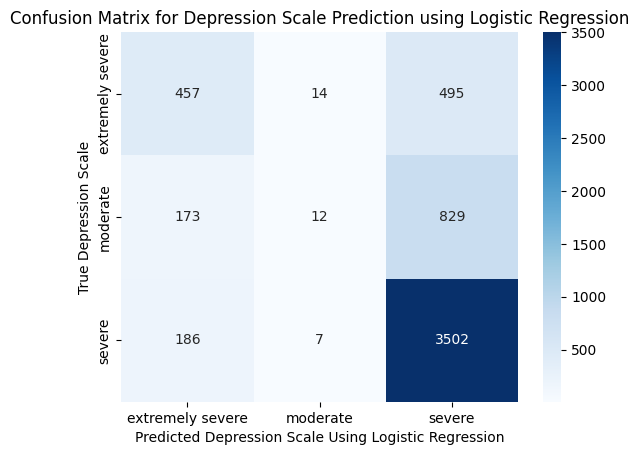

In [150]:
# Best model on the test data
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Generating classification report
report = classification_report(y_test, y_pred,output_dict=True)
logistic_depression_report = pd.DataFrame(report).transpose()

# Print the classification report
print("Classification Report for Depression Predicion using Logistic Regression:")
print(logistic_depression_report)

# Generating confusion matrix
logistic_depression_conf_matrix = confusion_matrix(y_test, y_pred)

sns.heatmap(logistic_depression_conf_matrix, annot=True, fmt='d', cmap='Blues',xticklabels=tick_labels, yticklabels=tick_labels)
plt.xlabel('Predicted Depression Scale Using Logistic Regression')
plt.ylabel('True Depression Scale')
plt.title('Confusion Matrix for Depression Scale Prediction using Logistic Regression')
plt.show()

# CLASSIC MACHINE LEARNING ALGORITHM - 2 (RANDOM FOREST FOR DEPRESSION PREDICTION):

In [151]:
# Random Forest
print("------------------------------------------------------------------------")
print("Random Forest for Depression Scale Prediction")
print("------------------------------------------------------------------------")

# Model pipeline
model = make_pipeline(RandomForestClassifier())

# Parameter grid for hyperparameter tuning
param_grid = {
    'randomforestclassifier__n_estimators': [100, 200, 300],  # Number of trees in the forest
    'randomforestclassifier__max_depth': [None, 10, 20],  # Maximum depth of the trees
}

# Perform GridSearchCV with cross-validation
grid_search = GridSearchCV(model, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Best model
best_model = grid_search.best_estimator_

# Best hyperparameters
best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)

------------------------------------------------------------------------
Random Forest for Depression Scale Prediction
------------------------------------------------------------------------
Best hyperparameters: {'randomforestclassifier__max_depth': None, 'randomforestclassifier__n_estimators': 200}


Accuracy: 0.7103083700440529
Classification Report for Depression Predicion using Random Forest:
              precision    recall  f1-score      support
2              0.681818  0.419255  0.519231   966.000000
3              0.376812  0.025641  0.048015  1014.000000
4              0.718276  0.974290  0.826921  3695.000000
accuracy       0.710308  0.710308  0.710308     0.710308
macro avg      0.592302  0.473062  0.464722  5675.000000
weighted avg   0.651058  0.710308  0.635372  5675.000000


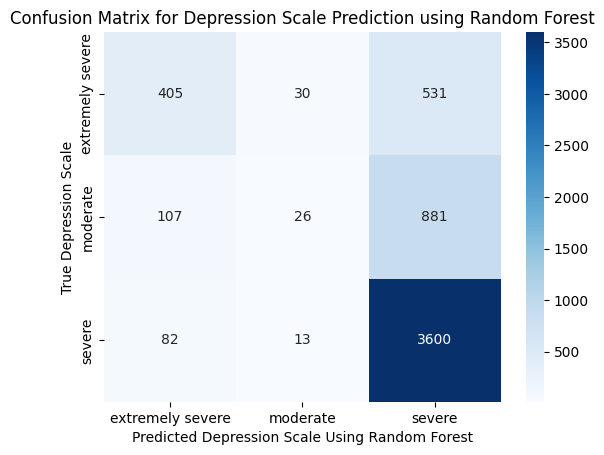

In [154]:
# Best model on the test data
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Generating classification report
report = classification_report(y_test, y_pred,output_dict=True)
rf_depression_report = pd.DataFrame(report).transpose()

# Print the classification report
print("Classification Report for Depression Predicion using Random Forest:")
print(rf_depression_report)

# Generating confusion matrix
rf_depression_conf_matrix = confusion_matrix(y_test, y_pred)

sns.heatmap(rf_depression_conf_matrix, annot=True, fmt='d', cmap='Blues',xticklabels=tick_labels, yticklabels=tick_labels)
plt.xlabel('Predicted Depression Scale Using Random Forest')
plt.ylabel('True Depression Scale')
plt.title('Confusion Matrix for Depression Scale Prediction using Random Forest')
plt.show()

# BAYESIAN NETWORK FOR DEPRESSION:

In [15]:
def map_depression_level(score):
    if score >= 49: return 'extremely severe'
    elif 40 <= score <= 48 : return 'severe'
    elif 31 <= score <= 39 : return 'moderate'
    elif 22 <= score <= 30: return 'mild'
    else: return 'normal'
    
depression_questions = ['Q2A','Q4A','Q7A','Q9A','Q15A','Q19A','Q20A','Q23A','Q25A','Q28A','Q30A','Q36A','Q40A','Q41A']
depression_df = das_df[depression_questions]
depression_df['level'] = depression_df.sum(axis=1).apply(map_depression_level)
depression_df.head()

,Q2A,Q4A,Q7A,Q9A,Q15A,Q19A,Q20A,Q23A,Q25A,Q28A,Q30A,Q36A,Q40A,Q41A,level
0,4,4,4,2,4,3,3,4,4,3,2,4,3,4,severe
1,1,3,3,3,3,1,1,1,2,4,3,3,1,2,moderate
2,1,1,1,2,4,2,1,2,2,1,2,4,2,1,mild
3,3,1,4,3,2,1,2,1,1,1,3,1,4,4,moderate
4,2,4,4,4,4,4,4,4,4,4,4,4,4,4,extremely severe


In [16]:
from sklearn.model_selection import train_test_split
depression_features = depression_df.drop('level',axis=1)
depression_label = depression_df['level']
X_train, X_test, y_train, y_test = train_test_split(depression_features, depression_label,
                                                    stratify=depression_label, 
                                                    test_size=0.2,random_state=10)
X_train['level'] = y_train

  0%|          | 0/1000000 [00:00<?, ?it/s]

[('Q2A', 'Q23A'), ('Q4A', 'Q25A'), ('Q4A', 'Q15A'), ('Q25A', 'Q2A'), ('Q7A', 'level'), ('Q7A', 'Q41A'), ('Q7A', 'Q15A'), ('Q7A', 'Q28A'), ('Q7A', 'Q40A'), ('level', 'Q28A'), ('level', 'Q20A'), ('level', 'Q36A'), ('level', 'Q4A'), ('level', 'Q40A'), ('level', 'Q41A'), ('level', 'Q9A'), ('level', 'Q25A'), ('level', 'Q30A'), ('level', 'Q15A'), ('level', 'Q23A'), ('level', 'Q19A'), ('level', 'Q2A'), ('Q41A', 'Q19A'), ('Q28A', 'Q36A'), ('Q28A', 'Q40A'), ('Q28A', 'Q2A'), ('Q28A', 'Q20A'), ('Q28A', 'Q9A'), ('Q40A', 'Q9A'), ('Q40A', 'Q30A'), ('Q9A', 'Q30A'), ('Q30A', 'Q4A'), ('Q30A', 'Q36A'), ('Q36A', 'Q20A'), ('Q36A', 'Q19A'), ('Q36A', 'Q25A')]
test accuracy: 0.9329981143934633
Classification Report for Depression Predicion using Bayesian Network:
                  precision    recall  f1-score      support
extremely severe   0.986150  0.841608  0.908163   423.000000
mild               0.922688  0.957661  0.939850  2480.000000
moderate           0.894066  0.933436  0.913327  1953.000000
norma

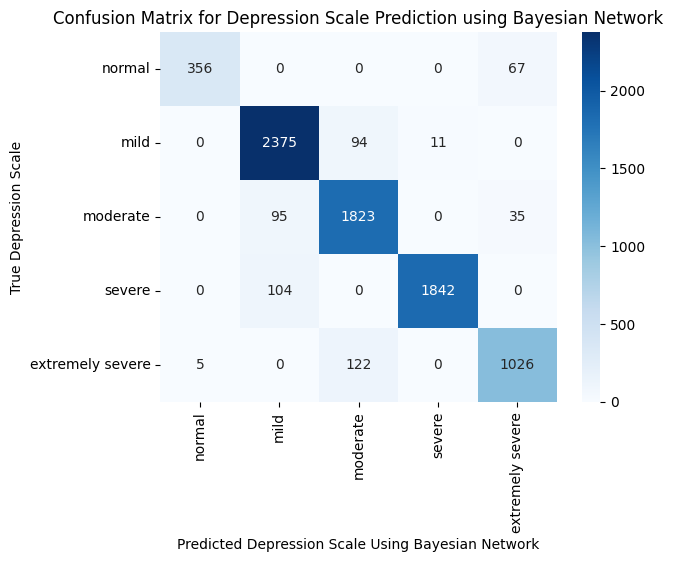

In [18]:


from pgmpy.estimators import HillClimbSearch
from pgmpy.models import BayesianNetwork

# Search for the best structure
hc = HillClimbSearch(X_train)
best_model = hc.estimate()

# Instantiate a BayesianModel object with the best structure
bayesian_network = BayesianNetwork(best_model.edges())
bayesian_network.fit(X_train)
print(bayesian_network.edges())
from pgmpy.inference import VariableElimination
strs_inference = VariableElimination(bayesian_network)

def predict_level_proba(df_row, inference, levels = ['extremely severe', 'severe', 'moderate', 'normal', 'mild']):
    if 'level' in df_row.keys():
        del df_row['level']
    posterior_probs = inference.query(variables=['level'], evidence=df_row)
    level_probas = -1
    max_proba_level = None
    for lvl in levels:
        proba = posterior_probs.get_value(level = lvl)
        if proba > level_probas:
            level_probas = proba
            max_proba_level = lvl
    return max_proba_level

total_x_test_len = len(X_test)
correct_test = 0
y_pred = []
for row in range(total_x_test_len):
    pred_level = predict_level_proba(X_test.iloc[row].to_dict(),strs_inference)
    if pred_level == y_test.iloc[row]: correct_test += 1
    y_pred.append(pred_level)
print('test accuracy:', correct_test/total_x_test_len)

# Generating classification report
report = classification_report(y_test, y_pred,output_dict=True)
rf_depression_report = pd.DataFrame(report).transpose()

# Print the classification report
print("Classification Report for Depression Predicion using Bayesian Network:")
print(rf_depression_report)

# Generating confusion matrix
rf_anxiety_conf_matrix = confusion_matrix(y_test, y_pred)
tick_labels = ['normal',  'mild' , 'moderate',  'severe',  'extremely severe']
sns.heatmap(rf_anxiety_conf_matrix, annot=True, fmt='d', cmap='Blues',xticklabels=tick_labels, yticklabels=tick_labels)
plt.xlabel('Predicted Depression Scale Using Bayesian Network')
plt.ylabel('True Depression Scale')
plt.title('Confusion Matrix for Depression Scale Prediction using Bayesian Network')
plt.show()

# NEURAL NETWORK FOR DEPRESSION:

Epoch 1/10
995/995 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8465 - loss: 0.4270 - val_accuracy: 0.9547 - val_loss: 0.1134
Epoch 2/10
995/995 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9718 - loss: 0.0775 - val_accuracy: 0.9783 - val_loss: 0.0572
Epoch 3/10
995/995 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9884 - loss: 0.0385 - val_accuracy: 0.9909 - val_loss: 0.0324
Epoch 4/10
995/995 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9916 - loss: 0.0268 - val_accuracy: 0.9935 - val_loss: 0.0210
Epoch 5/10
995/995 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9943 - loss: 0.0186 - val_accuracy: 0.9985 - val_loss: 0.0104
Epoch 6/10
995/995 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9919 - loss: 0.0217 - val_accuracy: 0.9930 - val_loss: 0.0144
Epoch 7/10
995/995 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9944 - loss: 0.0154 - val_accuracy: 0.9986 - val_loss: 0.0093
Epoch 8/10
995/995 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9971 - loss: 0.0096 - val_accuracy: 0.

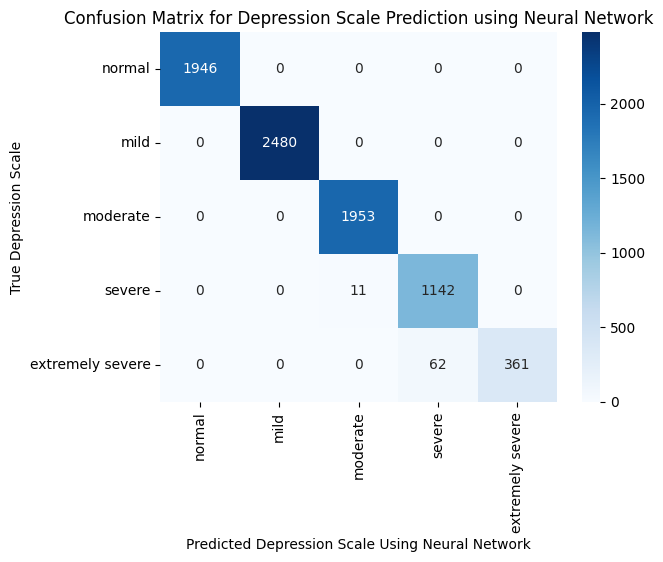

In [17]:
def norm(x: pd.DataFrame) -> pd.DataFrame:
    """Norm all columns to zero mean and unit standard deviation."""
    mean = x.describe().transpose()['mean']
    std = x.describe().transpose()['std']
    return (x - mean) / std

normed_train_data = norm(X_train.drop('level',axis=1))
normed_test_data = norm(X_test)

def level_numeric_map(lvl):
    if lvl == 'extremely severe' : return 4
    elif lvl == 'severe': return 3
    elif lvl == 'moderate': return 2
    elif lvl == 'mild': return 1
    else: return 0

y_train_num = y_train.map(level_numeric_map)
y_test_num = y_test.map(level_numeric_map)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Dense(128, activation='relu', input_shape=(normed_train_data.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dense(5, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(normed_train_data, y_train_num, epochs=10, validation_data=(normed_test_data, y_test_num))

import numpy as np
y_pred = [np.argmax(e) for e in model.predict(normed_test_data)]

# Generating classification report
report = classification_report(y_test_num, y_pred,output_dict=True)
rf_depression_report = pd.DataFrame(report).transpose()

# Print the classification report
print("Classification Report for Depression Predicion using Neural Network:")
print(rf_depression_report)

# Generating confusion matrix
rf_anxiety_conf_matrix = confusion_matrix(y_test_num, y_pred)
tick_labels = ['normal',  'mild' , 'moderate',  'severe',  'extremely severe']
sns.heatmap(rf_anxiety_conf_matrix, annot=True, fmt='d', cmap='Blues',xticklabels=tick_labels, yticklabels=tick_labels)
plt.xlabel('Predicted Depression Scale Using Neural Network')
plt.ylabel('True Depression Scale')
plt.title('Confusion Matrix for Depression Scale Prediction using Neural Network')
plt.show()

# ANXIETY SCALE PREDCITION - DATA PREPARATION

In [169]:
# Generate dataframe for Anxiety
columns_to_remove = [f"Q{i}A" for i in range(1, 43) ] \
                    + [f"Q{i}E" for i in depression_question ] + [f"Q{i}E" for i in stress_question ] \
                    + [f"Q{i}I" for i in depression_question ] + [f"Q{i}I" for i in stress_question ]

# Creating a new DataFrame for Anxiety without the specified columns
anxiety_df = df.drop(columns=columns_to_remove)
anxiety_df.drop(columns=['depression_score'], inplace=True)
anxiety_df.drop(columns=['stress_score'], inplace=True)

# Anxiety score mapping
# Define the mapping dictionary
score_mapping = {
    (0, 7): 0,
    (8, 9): 1,
    (10, 14): 2,
    (15, 19): 3,
    (20, float('inf')): 4
}

label_mapping = {0: 'normal', 1: 'mild' ,2: 'moderate', 3: 'severe', 4: 'extremely severe'}

# Map the anxiety scores to the specified ranges
anxiety_df['anxiety_score'] = anxiety_df['anxiety_score'].map(lambda x: next((v for k, v in score_mapping.items() if k[0] <= x <= k[1]), None))

# Print the DataFrame with mapped scores
print("Shape of Anxiety dataframe:", anxiety_df.shape)

# Defining features and target variable
y = anxiety_df['anxiety_score']
X = anxiety_df.drop(columns=['anxiety_score'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_unique = y_test.unique()
tick_labels = [label_mapping[val] for val in y_unique]


Shape of Anxiety dataframe: (28371, 106)


# CLASSIC MACHINE LEARNING ALGORITHM - 1 (LOGISTIC REGRESSION FOR ANXIETY PREDICTION)

In [156]:
# Logistic Regression
print("------------------------------------------------------------------------")
print("Logistic Regression for Anxiety Scale Prediction")
print("------------------------------------------------------------------------")

# Define the model pipeline
model = make_pipeline(StandardScaler(), LogisticRegression(multi_class='ovr', solver='liblinear'))

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'logisticregression__C': [0.1, 1, 10],  # Regularization parameter
}

# Perform GridSearchCV with cross-validation
grid_search = GridSearchCV(model, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Best model
best_model = grid_search.best_estimator_

# Best hyperparameters
best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)

------------------------------------------------------------------------
Logistic Regression for Anxiety Scale Prediction
------------------------------------------------------------------------
Best hyperparameters: {'logisticregression__C': 10}


Accuracy: 0.6997356828193833
Classification Report for Anxiety Predicion using Logistic Regression:
              precision    recall  f1-score      support
2              0.560049  0.473085  0.512907   966.000000
3              0.363636  0.011834  0.022923  1014.000000
4              0.725653  0.947767  0.821969  3695.000000
accuracy       0.699736  0.699736  0.699736     0.699736
macro avg      0.549779  0.477562  0.452600  5675.000000
weighted avg   0.632779  0.699736  0.626588  5675.000000


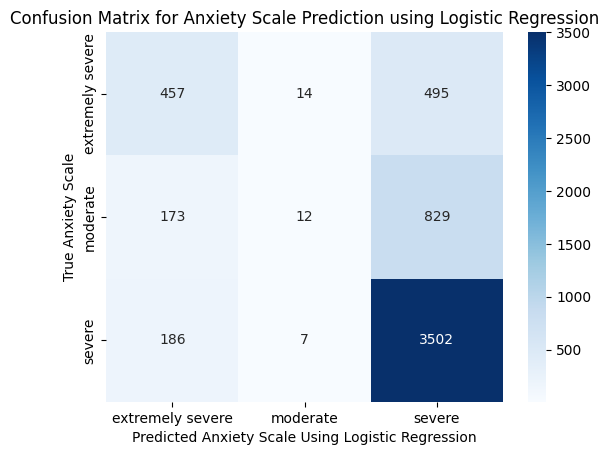

In [157]:
# Best model on the test data
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Generating classification report
report = classification_report(y_test, y_pred,output_dict=True)
logistic_anxiety_report = pd.DataFrame(report).transpose()

# Print the classification report
print("Classification Report for Anxiety Predicion using Logistic Regression:")
print(logistic_anxiety_report)

# Generating confusion matrix
logistic_anxiety_conf_matrix = confusion_matrix(y_test, y_pred)

sns.heatmap(logistic_anxiety_conf_matrix, annot=True, fmt='d', cmap='Blues',xticklabels=tick_labels, yticklabels=tick_labels)
plt.xlabel('Predicted Anxiety Scale Using Logistic Regression')
plt.ylabel('True Anxiety Scale')
plt.title('Confusion Matrix for Anxiety Scale Prediction using Logistic Regression')
plt.show()

# CLASSIC MACHINE LEARNING ALGORITHM - 2 (RANDOM FOREST FOR ANXIETY PREDICTION):

In [158]:
# Random Forest
print("------------------------------------------------------------------------")
print("Random Forest for Anxiety Scale Prediction")
print("------------------------------------------------------------------------")

# Model pipeline
model = make_pipeline(RandomForestClassifier())

# Parameter grid for hyperparameter tuning
param_grid = {
    'randomforestclassifier__n_estimators': [100, 200, 300],  # Number of trees in the forest
    'randomforestclassifier__max_depth': [None, 10, 20],  # Maximum depth of the trees
}

# Perform GridSearchCV with cross-validation
grid_search = GridSearchCV(model, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Best model
best_model = grid_search.best_estimator_

# Best hyperparameters
best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)

------------------------------------------------------------------------
Random Forest for Anxiety Scale Prediction
------------------------------------------------------------------------
Best hyperparameters: {'randomforestclassifier__max_depth': None, 'randomforestclassifier__n_estimators': 200}


Accuracy: 0.7115418502202643
Classification Report for Anxiety Predicion using Random Forest:
              precision    recall  f1-score      support
2              0.687708  0.428571  0.528061   966.000000
3              0.343750  0.021696  0.040816  1014.000000
4              0.719106  0.974831  0.827665  3695.000000
accuracy       0.711542  0.711542  0.711542     0.711542
macro avg      0.583521  0.475033  0.465514  5675.000000
weighted avg   0.646693  0.711542  0.636074  5675.000000


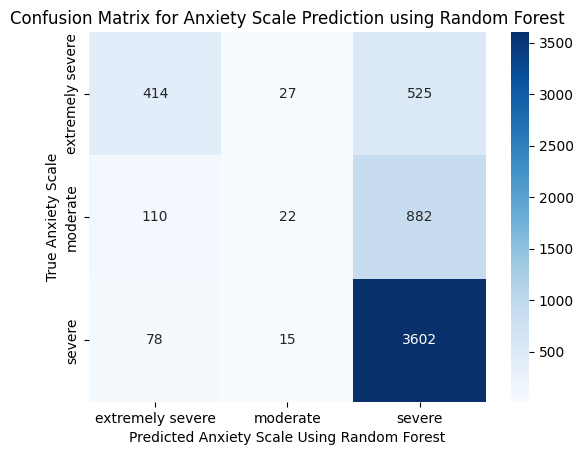

In [159]:
# Best model on the test data
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Generating classification report
report = classification_report(y_test, y_pred,output_dict=True)
rf_anxiety_report = pd.DataFrame(report).transpose()

# Print the classification report
print("Classification Report for Anxiety Predicion using Random Forest:")
print(rf_anxiety_report)

# Generating confusion matrix
rf_anxiety_conf_matrix = confusion_matrix(y_test, y_pred)

sns.heatmap(rf_anxiety_conf_matrix, annot=True, fmt='d', cmap='Blues',xticklabels=tick_labels, yticklabels=tick_labels)
plt.xlabel('Predicted Anxiety Scale Using Random Forest')
plt.ylabel('True Anxiety Scale')
plt.title('Confusion Matrix for Anxiety Scale Prediction using Random Forest')
plt.show()

# BAYESIAN NETWORK FOR ANXIETY:

In [1]:
import pandas as pd
df = pd.read_csv('./DASS_data_21.02.19/data.csv', sep='\t')
df.head()
questions = [f'Q{i}A' for i in range(1, 43)]
das_df = df[questions]

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
def map_anxiety_level(score):
    if score >= 49: return 'extremely severe'
    elif 40 <= score <= 48 : return 'severe'
    elif 31 <= score <= 39 : return 'moderate'
    elif 22 <= score <= 30: return 'mild'
    else: return 'normal'
    
anxiety_questions = ['Q2A','Q4A','Q7A','Q9A','Q15A','Q19A','Q20A','Q23A','Q25A','Q28A','Q30A','Q36A','Q40A','Q41A']
anxiety_df = das_df[anxiety_questions]
anxiety_df.head()
anxiety_df['level'] = anxiety_df.sum(axis=1).apply(map_anxiety_level)
anxiety_df.head()

,Q2A,Q4A,Q7A,Q9A,Q15A,Q19A,Q20A,Q23A,Q25A,Q28A,Q30A,Q36A,Q40A,Q41A,level
0,4,4,4,2,4,3,3,4,4,3,2,4,3,4,severe
1,1,3,3,3,3,1,1,1,2,4,3,3,1,2,moderate
2,1,1,1,2,4,2,1,2,2,1,2,4,2,1,mild
3,3,1,4,3,2,1,2,1,1,1,3,1,4,4,moderate
4,2,4,4,4,4,4,4,4,4,4,4,4,4,4,extremely severe


In [5]:
from sklearn.model_selection import train_test_split
anxiety_features = anxiety_df.drop('level',axis=1)
anxiety_label = anxiety_df['level']
X_train, X_test, y_train, y_test = train_test_split(anxiety_features, anxiety_label,
                                                    stratify=anxiety_label, 
                                                    test_size=0.2,random_state=10)
X_train['level'] = y_train

In [6]:
from pgmpy.estimators import HillClimbSearch
from pgmpy.models import BayesianNetwork

# Search for the best structure
hc = HillClimbSearch(X_train)
best_model = hc.estimate()

# Instantiate a BayesianModel object with the best structure
bayesian_network = BayesianNetwork(best_model.edges())
bayesian_network.fit(X_train)
print(bayesian_network.edges())

  0%|          | 0/1000000 [00:00<?, ?it/s]

[('Q2A', 'Q23A'), ('Q4A', 'Q25A'), ('Q4A', 'Q15A'), ('Q25A', 'Q2A'), ('Q7A', 'level'), ('Q7A', 'Q41A'), ('Q7A', 'Q15A'), ('Q7A', 'Q28A'), ('Q7A', 'Q40A'), ('level', 'Q28A'), ('level', 'Q20A'), ('level', 'Q36A'), ('level', 'Q4A'), ('level', 'Q40A'), ('level', 'Q41A'), ('level', 'Q9A'), ('level', 'Q25A'), ('level', 'Q30A'), ('level', 'Q15A'), ('level', 'Q23A'), ('level', 'Q19A'), ('level', 'Q2A'), ('Q41A', 'Q19A'), ('Q28A', 'Q36A'), ('Q28A', 'Q40A'), ('Q28A', 'Q2A'), ('Q28A', 'Q20A'), ('Q28A', 'Q9A'), ('Q40A', 'Q9A'), ('Q40A', 'Q30A'), ('Q9A', 'Q30A'), ('Q30A', 'Q4A'), ('Q30A', 'Q36A'), ('Q36A', 'Q20A'), ('Q36A', 'Q19A'), ('Q36A', 'Q25A')]


In [7]:
from pgmpy.inference import VariableElimination
anx_inference = VariableElimination(bayesian_network)

In [8]:
def predict_level_proba(df_row, inference, levels = ['extremely severe', 'severe', 'moderate', 'normal', 'mild']):
    if 'level' in df_row.keys():
        del df_row['level']
    posterior_probs = inference.query(variables=['level'], evidence=df_row)
    level_probas = -1
    max_proba_level = None
    for lvl in levels:
        proba = posterior_probs.get_value(level = lvl)
        if proba > level_probas:
            level_probas = proba
            max_proba_level = lvl
    return max_proba_level

In [10]:
total_x_test_len = len(X_test)
correct_test = 0
y_pred = []
for row in range(total_x_test_len):
    pred_level = predict_level_proba(X_test.iloc[row].to_dict(),anx_inference)
    if pred_level == y_test.iloc[row]: correct_test += 1
    y_pred.append(pred_level)
print('test accuracy:', correct_test/total_x_test_len)

test accuracy: 0.9329981143934633


Classification Report for Anxiety Predicion using Bayesian Network:
                  precision    recall  f1-score      support
extremely severe   0.986150  0.841608  0.908163   423.000000
mild               0.922688  0.957661  0.939850  2480.000000
moderate           0.894066  0.933436  0.913327  1953.000000
normal             0.994064  0.946557  0.969729  1946.000000
severe             0.909574  0.889853  0.899605  1153.000000
accuracy           0.932998  0.932998  0.932998     0.932998
macro avg          0.941308  0.913823  0.926135  7955.000000
weighted avg       0.934595  0.932998  0.933129  7955.000000


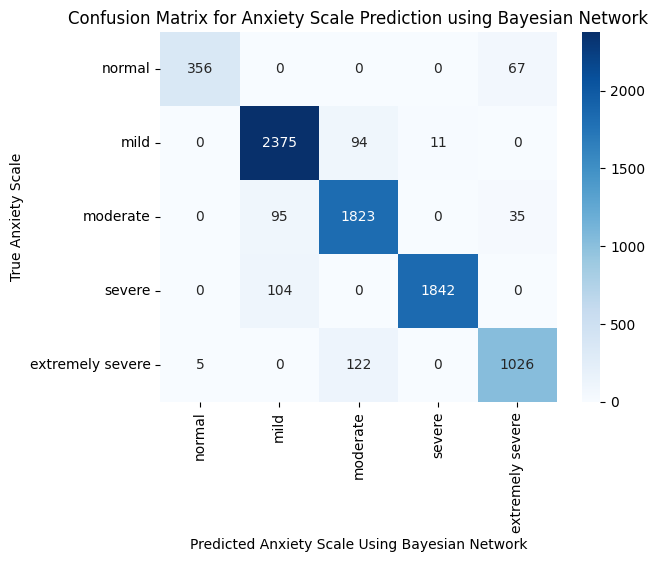

In [14]:
# Generating classification report
report = classification_report(y_test, y_pred,output_dict=True)
rf_anxiety_report = pd.DataFrame(report).transpose()

# Print the classification report
print("Classification Report for Anxiety Predicion using Bayesian Network:")
print(rf_anxiety_report)

# Generating confusion matrix
rf_anxiety_conf_matrix = confusion_matrix(y_test, y_pred)
tick_labels = ['normal',  'mild' , 'moderate',  'severe',  'extremely severe']
sns.heatmap(rf_anxiety_conf_matrix, annot=True, fmt='d', cmap='Blues',xticklabels=tick_labels, yticklabels=tick_labels)
plt.xlabel('Predicted Anxiety Scale Using Bayesian Network')
plt.ylabel('True Anxiety Scale')
plt.title('Confusion Matrix for Anxiety Scale Prediction using Bayesian Network')
plt.show()

# NEURAL NETWORK FOR ANXIETY:

In [28]:
def norm(x: pd.DataFrame) -> pd.DataFrame:
    """Norm all columns to zero mean and unit standard deviation."""
    mean = x.describe().transpose()['mean']
    std = x.describe().transpose()['std']
    return (x - mean) / std

normed_train_data = norm(X_train.drop('level',axis=1))
normed_test_data = norm(X_test)

def level_numeric_map(lvl):
    if lvl == 'extremely severe' : return 4
    elif lvl == 'severe': return 3
    elif lvl == 'moderate': return 2
    elif lvl == 'mild': return 1
    else: return 0

y_train_num = y_train.map(level_numeric_map)
y_test_num = y_test.map(level_numeric_map)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Dense(128, activation='relu', input_shape=(normed_train_data.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dense(5, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(normed_train_data, y_train_num, epochs=10, validation_data=(normed_test_data, y_test_num))

Epoch 1/10
995/995 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8459 - loss: 0.4402 - val_accuracy: 0.9558 - val_loss: 0.1047
Epoch 2/10
995/995 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9693 - loss: 0.0812 - val_accuracy: 0.9873 - val_loss: 0.0453
Epoch 3/10
995/995 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9842 - loss: 0.0474 - val_accuracy: 0.9933 - val_loss: 0.0279
Epoch 4/10
995/995 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9915 - loss: 0.0291 - val_accuracy: 0.9935 - val_loss: 0.0212
Epoch 5/10
995/995 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9930 - loss: 0.0217 - val_accuracy: 0.9982 - val_loss: 0.0104
Epoch 6/10
995/995 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9955 - loss: 0.0138 - val_accuracy: 0.9962 - val_loss: 0.0110
Epoch 7/10
995/995 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9952 - loss: 0.0142 - val_accuracy: 0.9912 - val_loss: 0.0179
Epoch 8/10
995/995 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9959 - loss: 0.0103 - val_accuracy: 0.

In [37]:
import numpy as np
y_pred = [np.argmax(e) for e in model.predict(normed_test_data)]

249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Classification Report for Anxiety Predicion using Neural Network:
              precision    recall  f1-score      support
0              1.000000  1.000000  1.000000  1946.000000
1              1.000000  1.000000  1.000000  2480.000000
2              0.999488  1.000000  0.999744  1953.000000
3              0.998255  0.992194  0.995215  1153.000000
4              0.981352  0.995272  0.988263   423.000000
accuracy       0.998617  0.998617  0.998617     0.998617
macro avg      0.995819  0.997493  0.996644  7955.000000
weighted avg   0.998630  0.998617  0.998620  7955.000000


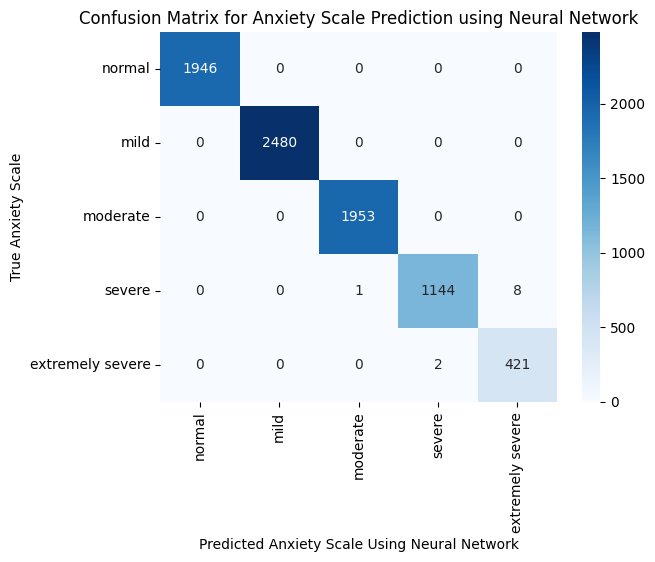

In [38]:
# Generating classification report
report = classification_report(y_test_num, y_pred,output_dict=True)
rf_anxiety_report = pd.DataFrame(report).transpose()

# Print the classification report
print("Classification Report for Anxiety Predicion using Neural Network:")
print(rf_anxiety_report)

# Generating confusion matrix
rf_anxiety_conf_matrix = confusion_matrix(y_test_num, y_pred)
tick_labels = ['normal',  'mild' , 'moderate',  'severe',  'extremely severe']
sns.heatmap(rf_anxiety_conf_matrix, annot=True, fmt='d', cmap='Blues',xticklabels=tick_labels, yticklabels=tick_labels)
plt.xlabel('Predicted Anxiety Scale Using Neural Network')
plt.ylabel('True Anxiety Scale')
plt.title('Confusion Matrix for Anxiety Scale Prediction using Neural Network')
plt.show()

# STRESS SCALE PREDCITION - DATA PREPARATION

In [160]:
# Generate dataframe for Stress
columns_to_remove = [f"Q{i}A" for i in range(1, 43) ] \
                    + [f"Q{i}E" for i in depression_question ] + [f"Q{i}E" for i in anxiety_question ] \
                    + [f"Q{i}I" for i in depression_question ] + [f"Q{i}I" for i in anxiety_question ]

# Creating a new DataFrame for Anxiety without the specified columns
stress_df = df.drop(columns=columns_to_remove)
stress_df.drop(columns=['depression_score'], inplace=True)
stress_df.drop(columns=['anxiety_score'], inplace=True)

# Stress score mapping
# Define the mapping dictionary
score_mapping = {
    (0, 14): 0,
    (15, 18): 1,
    (19, 25): 2,
    (26, 33): 3,
    (34, float('inf')): 4
}

# Map the stress scores to the specified ranges
stress_df['stress_score'] = stress_df['stress_score'].map(lambda x: next((v for k, v in score_mapping.items() if k[0] <= x <= k[1]), None))

# Print the DataFrame with mapped scores
print("Shape of Stress dataframe:", stress_df.shape)


# Defining features and target variable
y = stress_df['stress_score']
X = stress_df.drop(columns=['stress_score'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_unique = y_test.unique()
tick_labels = [label_mapping[val] for val in y_unique]

Shape of Stress dataframe: (28371, 106)


# CLASSIC MACHINE LEARNING ALGORITHM - 1 (LOGISTIC REGRESSION FOR STRESS PREDICTION)

In [ ]:
# Logistic Regression
print("------------------------------------------------------------------------")
print("Logistic Regression for Stress Scale Prediction")
print("------------------------------------------------------------------------")

# Define the model pipeline
model = make_pipeline(StandardScaler(), LogisticRegression(multi_class='ovr', solver='liblinear'))

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'logisticregression__C': [0.1, 1, 10],  # Regularization parameter
}

# Perform GridSearchCV with cross-validation
grid_search = GridSearchCV(model, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Best model
best_model = grid_search.best_estimator_

# Best hyperparameters
best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)

In [ ]:
# Best model on the test data
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Generating classification report
report = classification_report(y_test, y_pred,output_dict=True)
logistic_stress_report = pd.DataFrame(report).transpose()

# Print the classification report
print("Classification Report for Stress Predicion using Logistic Regression:")
print(logistic_stress_report)

# Generating confusion matrix
logistic_stress_conf_matrix = confusion_matrix(y_test, y_pred)

sns.heatmap(logistic_stress_conf_matrix, annot=True, fmt='d', cmap='Blues',xticklabels=tick_labels, yticklabels=tick_labels)
plt.xlabel('Predicted Stress Scale Using Logistic Regression')
plt.ylabel('True Stress Scale')
plt.title('Confusion Matrix for Stress Scale Prediction using Logistic Regression')
plt.show()

# CLASSIC MACHINE LEARNING ALGORITHM - 2 (RANDOM FOREST FOR STRESS PREDICTION)

In [ ]:
# Random Forest
print("------------------------------------------------------------------------")
print("Random Forest for Stress Scale Prediction")
print("------------------------------------------------------------------------")

# Model pipeline
model = make_pipeline(RandomForestClassifier())

# Parameter grid for hyperparameter tuning
param_grid = {
    'randomforestclassifier__n_estimators': [100, 200, 300],  # Number of trees in the forest
    'randomforestclassifier__max_depth': [None, 10, 20],  # Maximum depth of the trees
}

# Perform GridSearchCV with cross-validation
grid_search = GridSearchCV(model, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Best model
best_model = grid_search.best_estimator_

# Best hyperparameters
best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)

In [ ]:
# Best model on the test data
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Generating classification report
report = classification_report(y_test, y_pred,output_dict=True)
rf_stress_report = pd.DataFrame(report).transpose()

# Print the classification report
print("Classification Report for Stress Predicion using Random Forest:")
print(rf_stress_report)

# Generating confusion matrix
rf_stress_conf_matrix = confusion_matrix(y_test, y_pred)

sns.heatmap(rf_stress_conf_matrix, annot=True, fmt='d', cmap='Blues',xticklabels=tick_labels, yticklabels=tick_labels)
plt.xlabel('Predicted Stress Scale Using Random Forest')
plt.ylabel('True Stress Scale')
plt.title('Confusion Matrix for Stress Scale Prediction using Random Forest')
plt.show()

# BAYESIAN NETWORK FOR STRESS

In [8]:
def map_stress_level(score):
    if score >= 49: return 'extremely severe'
    elif 40 <= score <= 48 : return 'severe'
    elif 31 <= score <= 39 : return 'moderate'
    elif 22 <= score <= 30: return 'mild'
    else: return 'normal'
    
stress_questions = ['Q1A','Q6A','Q8A','Q11A','Q12A','Q14A','Q18A','Q22A','Q27A','Q29A','Q32A','Q33A','Q35A','Q39A']
stress_df = das_df[stress_questions]
stress_df['level'] = stress_df.sum(axis=1).apply(map_stress_level)
stress_df.head()

,Q1A,Q6A,Q8A,Q11A,Q12A,Q14A,Q18A,Q22A,Q27A,Q29A,Q32A,Q33A,Q35A,Q39A,level
0,4,4,4,4,4,4,4,4,4,4,4,2,4,4,extremely severe
1,4,4,4,2,2,4,2,3,3,3,3,3,2,2,severe
2,3,3,3,2,1,1,2,3,2,2,3,1,3,2,moderate
3,2,3,2,2,1,4,1,1,4,3,1,2,1,3,mild
4,2,2,4,2,4,4,4,3,2,2,4,4,3,3,severe


  0%|          | 0/1000000 [00:00<?, ?it/s]

[('Q1A', 'Q6A'), ('Q1A', 'Q22A'), ('Q1A', 'Q8A'), ('Q1A', 'Q33A'), ('Q1A', 'Q14A'), ('Q22A', 'Q8A'), ('Q8A', 'Q33A'), ('Q8A', 'Q29A'), ('Q33A', 'Q12A'), ('Q33A', 'Q14A'), ('Q14A', 'Q35A'), ('Q11A', 'level'), ('Q11A', 'Q1A'), ('Q11A', 'Q18A'), ('Q11A', 'Q27A'), ('Q11A', 'Q29A'), ('Q11A', 'Q6A'), ('level', 'Q1A'), ('level', 'Q29A'), ('level', 'Q27A'), ('level', 'Q39A'), ('level', 'Q8A'), ('level', 'Q22A'), ('level', 'Q6A'), ('level', 'Q33A'), ('level', 'Q12A'), ('level', 'Q32A'), ('level', 'Q35A'), ('level', 'Q18A'), ('level', 'Q14A'), ('Q27A', 'Q39A'), ('Q27A', 'Q18A'), ('Q12A', 'Q27A'), ('Q35A', 'Q32A')]
test accuracy: 0.9331238214959146
Classification Report for Stress Predicion using Bayesian Network:
                  precision    recall  f1-score      support
extremely severe   0.970852  0.882773  0.924720   981.000000
mild               0.951487  0.930612  0.940934  1960.000000
moderate           0.906383  0.950045  0.927700  2242.000000
normal             0.987074  0.945946  0.96

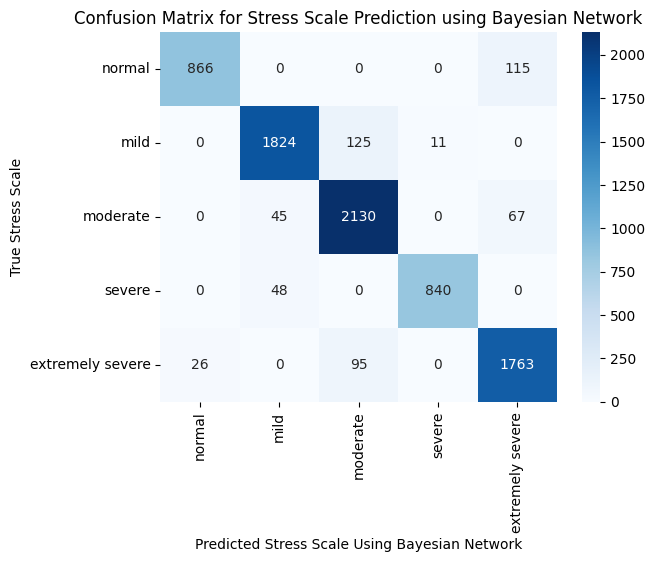

In [12]:
from sklearn.model_selection import train_test_split
stress_features = stress_df.drop('level',axis=1)
stress_label = stress_df['level']
X_train, X_test, y_train, y_test = train_test_split(stress_features, stress_label,
                                                    stratify=stress_label, 
                                                    test_size=0.2,random_state=10)
X_train['level'] = y_train

from pgmpy.estimators import HillClimbSearch
from pgmpy.models import BayesianNetwork

# Search for the best structure
hc = HillClimbSearch(X_train)
best_model = hc.estimate()

# Instantiate a BayesianModel object with the best structure
bayesian_network = BayesianNetwork(best_model.edges())
bayesian_network.fit(X_train)
print(bayesian_network.edges())
from pgmpy.inference import VariableElimination
strs_inference = VariableElimination(bayesian_network)

def predict_level_proba(df_row, inference, levels = ['extremely severe', 'severe', 'moderate', 'normal', 'mild']):
    if 'level' in df_row.keys():
        del df_row['level']
    posterior_probs = inference.query(variables=['level'], evidence=df_row)
    level_probas = -1
    max_proba_level = None
    for lvl in levels:
        proba = posterior_probs.get_value(level = lvl)
        if proba > level_probas:
            level_probas = proba
            max_proba_level = lvl
    return max_proba_level

total_x_test_len = len(X_test)
correct_test = 0
y_pred = []
for row in range(total_x_test_len):
    pred_level = predict_level_proba(X_test.iloc[row].to_dict(),strs_inference)
    if pred_level == y_test.iloc[row]: correct_test += 1
    y_pred.append(pred_level)
print('test accuracy:', correct_test/total_x_test_len)

# Generating classification report
report = classification_report(y_test, y_pred,output_dict=True)
rf_stress_report = pd.DataFrame(report).transpose()

# Print the classification report
print("Classification Report for Stress Predicion using Bayesian Network:")
print(rf_stress_report)

# Generating confusion matrix
rf_anxiety_conf_matrix = confusion_matrix(y_test, y_pred)
tick_labels = ['normal',  'mild' , 'moderate',  'severe',  'extremely severe']
sns.heatmap(rf_anxiety_conf_matrix, annot=True, fmt='d', cmap='Blues',xticklabels=tick_labels, yticklabels=tick_labels)
plt.xlabel('Predicted Stress Scale Using Bayesian Network')
plt.ylabel('True Stress Scale')
plt.title('Confusion Matrix for Stress Scale Prediction using Bayesian Network')
plt.show()

# NEURAL NETWORK FOR STRESS:

Epoch 1/10
995/995 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8448 - loss: 0.4461 - val_accuracy: 0.9779 - val_loss: 0.0781
Epoch 2/10
995/995 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9788 - loss: 0.0708 - val_accuracy: 0.9938 - val_loss: 0.0332
Epoch 3/10
995/995 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9876 - loss: 0.0374 - val_accuracy: 0.9923 - val_loss: 0.0233
Epoch 4/10
995/995 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9896 - loss: 0.0301 - val_accuracy: 0.9750 - val_loss: 0.0407
Epoch 5/10
995/995 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9928 - loss: 0.0223 - val_accuracy: 0.9991 - val_loss: 0.0091
Epoch 6/10
995/995 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9959 - loss: 0.0148 - val_accuracy: 0.9977 - val_loss: 0.0110
Epoch 7/10
995/995 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9941 - loss: 0.0205 - val_accuracy: 1.0000 - val_loss: 0.0043
Epoch 8/10
995/995 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9984 - loss: 0.0072 - val_accuracy: 0.

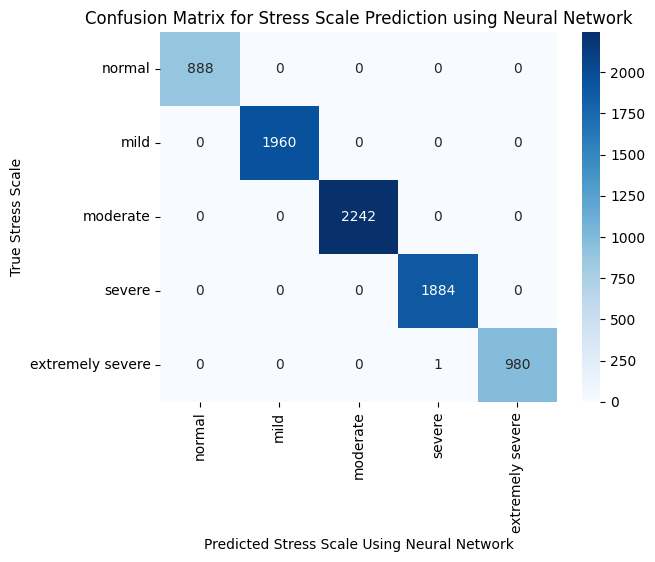

In [13]:
def norm(x: pd.DataFrame) -> pd.DataFrame:
    """Norm all columns to zero mean and unit standard deviation."""
    mean = x.describe().transpose()['mean']
    std = x.describe().transpose()['std']
    return (x - mean) / std

normed_train_data = norm(X_train.drop('level',axis=1))
normed_test_data = norm(X_test)

def level_numeric_map(lvl):
    if lvl == 'extremely severe' : return 4
    elif lvl == 'severe': return 3
    elif lvl == 'moderate': return 2
    elif lvl == 'mild': return 1
    else: return 0

y_train_num = y_train.map(level_numeric_map)
y_test_num = y_test.map(level_numeric_map)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Dense(128, activation='relu', input_shape=(normed_train_data.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dense(5, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(normed_train_data, y_train_num, epochs=10, validation_data=(normed_test_data, y_test_num))

import numpy as np
y_pred = [np.argmax(e) for e in model.predict(normed_test_data)]

# Generating classification report
report = classification_report(y_test_num, y_pred,output_dict=True)
rf_stress_report = pd.DataFrame(report).transpose()

# Print the classification report
print("Classification Report for Stress Predicion using Neural Network:")
print(rf_stress_report)

# Generating confusion matrix
rf_anxiety_conf_matrix = confusion_matrix(y_test_num, y_pred)
tick_labels = ['normal',  'mild' , 'moderate',  'severe',  'extremely severe']
sns.heatmap(rf_anxiety_conf_matrix, annot=True, fmt='d', cmap='Blues',xticklabels=tick_labels, yticklabels=tick_labels)
plt.xlabel('Predicted Stress Scale Using Neural Network')
plt.ylabel('True Stress Scale')
plt.title('Confusion Matrix for Stress Scale Prediction using Neural Network')
plt.show()